![image](https://www.ewatercycle.org/img/logo.png)

# Case study 3: replace internal evaporation module of PCRGlobWB2.0 with external data source
This notebooks demonstrates how to use eWaterCycle to 'interfere' in a model. Every timestep, the evaporation of PCRGlobWB is 'corrected' to reflect the evaporation as calucalated by ERA5. In this way, the model is forced by both precipitation and evaporation from ERA5. 

## Import statements
We'll be using the following modules

In [1]:
# TODO: clean up code to consistently use the same convention! This is now a mess of 
# double imports because this notebook is constructed from two example notebooks 
# written by different team members at different times in the project.

#OS related 
from os import environ, remove
from os.path import abspath
import os
from pathlib import Path
from glob import glob
from configparser import ConfigParser

#Time and time object related
import time
from datetime import datetime
from cftime import num2date

#calculations and plotting
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as sio
import xarray as xr
from scipy import optimize
from tqdm import tqdm

#cartography (drawing maps)
from cartopy.io import shapereader
from cartopy import crs

#hydrological specific non eWaterCycle
import hydrostats.metrics as hm
import hydrostats.visual as hv

#eWaterCycle specific
from ewatercycle.observation.grdc import get_grdc_data
from grpc4bmi.bmi_client_docker import BmiClientDocker

In [2]:
import pickle

## functions needed

The following functions are needed for this experiment.

TO DO: all of these need to become part of libraries, or at least be moved to a supporting .py file that is imported above

In [3]:
# This function takes an BMI model object, extracts variable and stores it 
# as an xarray object. For this to work, the variable does need to have a propper
# setup grid. See the BMI documentation on grids.

def var_to_xarray(model, variable):
    # Get grid properties from model (x = latitude !!)
    # could be speedup, lots of bmi calls are done here that dont change between updates
    shape = model.get_grid_shape(model.get_var_grid(variable))
    lat = model.get_grid_x(model.get_var_grid(variable))
    lon = model.get_grid_y(model.get_var_grid(variable))
    time = num2date(model.get_current_time(), model.get_time_units())

    # Get model data for variable at current timestep
    data = model.get_value(variable)
    data = np.reshape(data, shape)

    # Create xarray object
    da = xr.DataArray(data, 
                      coords = {'longitude': lon, 'latitude': lat, 'time': time}, 
                      dims = ['latitude', 'longitude'],
                      name = variable,
                      attrs = {'units': model.get_var_units(variable)}
                     )

    # Masked invalid values on return array:
    return da.where(da != -999)

In [4]:
# The following two functions translate lat,lon coordinates into BMI model 
# indices, which are used to get and set variable values.

def lat_lon_to_closest_variable_indices(model, variable, lats, lons):
    
    #get shape of model grid and lat-lon coordinates of grid
    shape = model.get_grid_shape(model.get_var_grid(variable))
    latModel = model.get_grid_x(model.get_var_grid(variable))
    lonModel = model.get_grid_y(model.get_var_grid(variable))
    nx = len(latModel)
    
    #for each coordinate given, determine where in the grid they fall and 
    #calculate 1D indeces
    if len(lats) == 1:
        idx = np.abs(latModel - lats).argmin()
        idy = np.abs(lonModel - lons).argmin()
        output = idx+nx*idy
    else:
        output=[]
        for [lat,lon] in [lats,lons]:
            idx = np.abs(latModel - lat).argmin()
            idy = np.abs(lonModel - lon).argmin()
            output.append(idx+nx*idy) 

    return np.array(output)

def lat_lon_boundingbox_to_variable_indices(model, variable, latMin, latMax, lonMin, lonMax):
    #get shape of model grid and lat-lon coordinates of grid
    shape = model.get_grid_shape(model.get_var_grid(variable))
    latModel = model.get_grid_x(model.get_var_grid(variable))
    lonModel = model.get_grid_y(model.get_var_grid(variable))
    nx = len(latModel)

    idx = [i for i,v in enumerate(latModel) if ((v > latMin) and (v < latMax))]
    idy = [i for i,v in enumerate(lonModel) if ((v > lonMin) and (v < lonMax))]
    
    output = []
    for x in idx:
        for y in idy:
            output.append(x + nx*y)
    
    return np.array(output)

## List of files created for this experiment

### for PCRGlobWB2.0

- `rhine_05min_era5.ini` This file is identical to the file with the same name used in the big comparison study. The only difference is that the time period (variables startTime and endTime) have been set to 2002-01-01 and 2002-12-31 respectivly. 



## Settings and parameters to run this experiment
The settings below are seperated in settings that 'belong' to the experiment, those that belong to PCRGlobWB or those that belong with MARRMoT

In [5]:
#Settings for this experiment

# The project home directory where data lives and output should be written
PROJECT_HOME = Path(os.path.abspath("/mnt/home/user42/case2"))
DATA_HOME = Path(os.path.abspath("/mnt/data/examples/technical_paper"))

# Settings for GRDC station for final comparison of streamflow
dstart = '2002-01-01'
dend = '2002-12-31'
station_id = '6335020' # GRDC station ID
basin_name = 'Rhine'



In [6]:
#Settings for PCRGlobWB2.0
PCRGlob_input_dir=str(DATA_HOME / 'pcr-globwb' / 'input')
PCRGlob_Ref_output_dir=str(PROJECT_HOME / 'PCRGlobREFOutput')
PCRGlob_Exp_output_dir=str(PROJECT_HOME / 'PCRGlobExpOutput')
#forcing_dir = '/mnt/data/examples/technical_paper/pcr-globwb/input/'

PCRGlob_setting_file = str(PROJECT_HOME / 'technicalPaperExampleNotebooks' / 'settingFiles' 
                           / 'pcrglobwb_Merrimack_ERA5')


## Setting up the model objects

In [7]:
# start up a container for PCRGlob for the reference run 
# and initialize using the setting file
PCRGlob_Ref_model = BmiClientDocker(image='ewatercycle/pcrg-grpc4bmi:setters', image_port=55555,

                   input_dir=PCRGlob_input_dir,

                   output_dir=PCRGlob_Ref_output_dir)

 

PCRGlob_Ref_model.initialize(PCRGlob_setting_file)

NameError: name 'PCRGlob_Ref_setting_file' is not defined

In [8]:
PCRGlob_Ref_model.initialize(PCRGlob_setting_file)

_InactiveRpcError: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.UNKNOWN
	details = "Exception calling application: 'Configuration' object has no attribute 'globalOptions'"
	debug_error_string = "{"created":"@1612298831.343015040","description":"Error received from peer ipv6:[::1]:55959","file":"src/core/lib/surface/call.cc","file_line":1055,"grpc_message":"Exception calling application: 'Configuration' object has no attribute 'globalOptions'","grpc_status":2}"
>

In [10]:
PCRGlob_Ref_model.finalize()
del PCRGlob_Ref_model

In [ ]:
# start up a container for PCRGlob for the reference run 
# and initialize using the setting file
PCRGlob_Exp_model = BmiClientDocker(image='ewatercycle/pcrg-grpc4bmi:setters', image_port=55555,

                   input_dir=PCRGlob_input_dir,

                   output_dir=PCRGlob_Exp_output_dir)

 

PCRGlob_Exp_model.initialize(PCRGlob_setting_file)

In [16]:
#finally, create variables needed during the experiment run
PCRGlob_Ref_output = []
PCRGlob_Exp_output = []

PCRGlob_time_units = PCRGlob_Exp_model.get_time_units()

## Running the experiment
With all pieces in place, we can now start to run the actual experiment. Since both models (reference and epxeriment) do not interact, they can be run in seperate loops and (ideally) this should be done in parallel.

In [17]:
print(f'Running experiment', flush=True)

#the experiment model is used as central 'time keeper'
while PCRGlob_Exp_model.get_current_time() < PCRGlob_Exp_model.get_end_time():
    
    #get the current time to print
    time = num2date(PCRGlob_Exp_model.get_current_time(), PCRGlob_time_units)
    print(f'Current time: {time}', end="\r")

    #run the reference model for one timestep, store the output
    PCRGlob_Ref_model.update()
    PCRGlob_Ref_output.append(var_to_xarray(PCRGlob_Ref_model, variable="discharge"))
    
    #run MARRMoT and store the output, note that MARRMoT output is in mm!
    MARRMoT_model.update()
    MARRMot_output.append(MARRMoT_model.get_value(MARRMoT_output_variable)[0])
    
    #add the output of MARRMoT to PCRGlob Experiment model. Note that channel storage
    # is in m3, while MARRMoT output is in mm, so we need to convert
    water_to_add_to_PCRGlob = MARRMot_output[-1] * moselle_area / 1000 #now in m3
    value_to_set_in_PCRGlob = water_to_add_to_PCRGlob + PCRGlob_Exp_model.get_value_at_indices('channel_storage',Moselle_mouth_indices)
    PCRGlob_Exp_model.set_value_at_indices('channel_storage',Moselle_mouth_indices, value_to_set_in_PCRGlob)
    
    #Run the experiment PCRGlobWB model one timestep, store the output
    PCRGlob_Exp_model.update()
    PCRGlob_Exp_output.append(var_to_xarray(PCRGlob_Exp_model, variable="discharge"))
    

print('')

Running experiment
Current time: 2002-12-30 00:00:00


### clean up after the model run
The models have to be 'finalized', which deletes any temporary files and the containers have to be shut down.

In [18]:
PCRGlob_Ref_model.finalize()
PCRGlob_Exp_model.finalize()
MARRMoT_model.finalize()

del PCRGlob_Exp_model
del PCRGlob_Ref_model
del MARRMoT_model

In [33]:
f = open('.\..\modelrunFull.pckl', 'wb')
pickle.dump([PCRGlob_Ref_output, PCRGlob_Exp_output, MARRMot_output],f)
f.close()
del f

## Import GRDC observations

Read the GRDC data for the period of the experiment, for the station given above. 
If you are not on jupyter.ewatercycle.org or cartesius, download the GRDC https://www.bafg.de/GRDC/EN/02_srvcs/21_tmsrs/riverdischarge_node.html and set the directory below in GRDC_DATA_HOME env var.

### TODO the four lines at the end of the cell should become part of the get_grdc_data function, which (I think) should return a dict.

In [20]:
#on Cartesius:
#environ['GRDC_DATA_HOME']= '/projects/0/wtrcycle/GRDC/GRDC_GCOSGTN-H_27_03_2019'

#on jupyter.ewatercycle.org
environ['GRDC_DATA_HOME']= '/mnt/data/grdc/dailies' 

observations = get_grdc_data(station_id, start_date=dstart, end_date=dend)
grdc_obs = observations.to_dataframe().rename(columns = {'streamflow': 'GRDC'})
grdc_lon = observations.attrs['grdc_longitude_in_arc_degree']
grdc_lat = observations.attrs['grdc_latitude_in_arc_degree']

## Plot the results

In [35]:
#f = open('.\..\modelrunFull.pckl', 'rb')
#data = pickle.load(f)
#f.close()
#del f

In [22]:
dataExp  = xr.concat(PCRGlob_Exp_output, dim='time')
dataRef  = xr.concat(PCRGlob_Ref_output, dim='time')

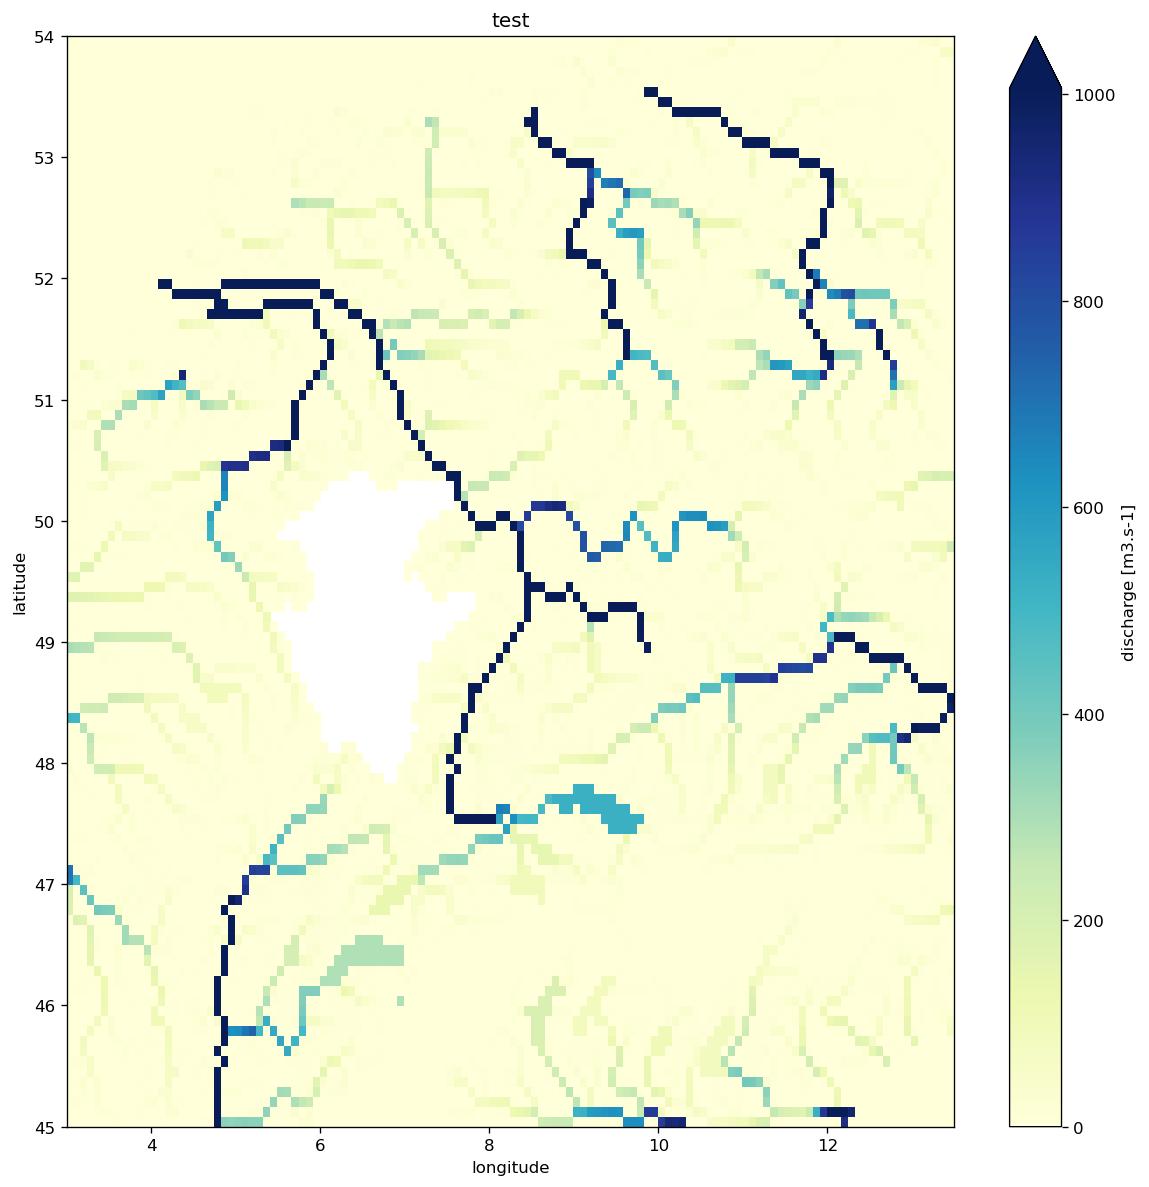

In [23]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10), dpi=120)

dataExp.isel(time=-1).plot(ax=axs, cmap='YlGnBu', robust=True)
axs.set_title('test')
plt.tight_layout()
fig.savefig(f'pcrglobwb_RolfTestRhine_discharge_map', bbox_inches='tight', dpi=300)

In [24]:
pad=.2

# Write data for model output at GRDC location to pandas series,
# Use padding and max to correct for GRDC station location error
dataExpAtGRDCLocation = dataExp.sel(longitude=slice(grdc_lon-pad, grdc_lon+pad), 
                         latitude=slice(grdc_lat-pad, grdc_lat+pad)
                        ).max(['longitude', 'latitude']
                        ).rename('ERA5Exp'
                        ).to_dataframe()

dataExpAtGRDCLocation.index=dataExpAtGRDCLocation.index.to_datetimeindex()

dataRefAtGRDCLocation = dataRef.sel(longitude=slice(grdc_lon-pad, grdc_lon+pad), 
                         latitude=slice(grdc_lat-pad, grdc_lat+pad)
                        ).max(['longitude', 'latitude']
                        ).rename('ERA5Ref'
                        ).to_dataframe()

dataRefAtGRDCLocation.index=dataRefAtGRDCLocation.index.to_datetimeindex()



In [25]:
# Combine timeseries of ERA-Interim, ERA5 and GRDC observations in a pandas dataframe
df = pd.concat([dataExpAtGRDCLocation, dataRefAtGRDCLocation, grdc_obs],axis = 1)

# Note: the data come at different time stamps
print(df.head())

# For now, interpolating to get similar sets:
df = df.fillna(method='ffill').dropna()
print(df.head())

                ERA5Exp      ERA5Ref    GRDC
2002-01-01  4551.247559  4551.247559  4120.0
2002-01-02  4682.305664  4709.530273  5010.0
2002-01-03  4199.963867  4644.274902  5220.0
2002-01-04  3453.768799  3974.360352  4460.0
2002-01-05  2125.878906  2586.708740  3570.0
                ERA5Exp      ERA5Ref    GRDC
2002-01-01  4551.247559  4551.247559  4120.0
2002-01-02  4682.305664  4709.530273  5010.0
2002-01-03  4199.963867  4644.274902  5220.0
2002-01-04  3453.768799  3974.360352  4460.0
2002-01-05  2125.878906  2586.708740  3570.0


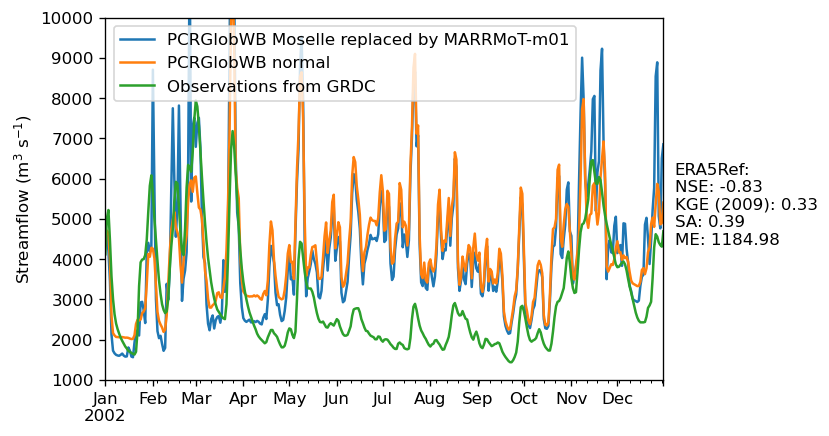

In [32]:
fig, ax = plt.subplots(dpi=120)
df.plot(ax=ax)
ax.set_ylim(1000, 10000)
ax.set_ylabel('Streamflow (m$^3$ s$^{-1}$)')
ax.legend(['PCRGlobWB Moselle replaced by MARRMoT-m01','PCRGlobWB normal','Observations from GRDC'])

dataset='ERA5Ref'
yloc=0.6
ax.text(1.02, yloc, f"{dataset}:\n"
        f"NSE: {hm.nse(df[dataset], df['GRDC']):.2f} \n"
        f"KGE (2009): {hm.kge_2009(df[dataset], df['GRDC']):.2f}\n"
        f"SA: {hm.sa(df[dataset], df['GRDC']):.2f}\n"
        f"ME: {hm.me(df[dataset], df['GRDC']):.2f}",
        transform=ax.transAxes, va='top')

fig.savefig(f'pcrglobwb_{basin_name}_hydrograph', bbox_inches='tight', dpi=300)
